<a href="https://colab.research.google.com/github/TalesMiguel/RNA/blob/main/Trabalho_final_RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto Final para a disciplina de Introdução às Redes Neurais Artificiais**
## **Classificação de áudio utilizando Redes Neurais Convolucionais**
### **Feito por:**
Camilo Maia Pires - 140473

Tales Miguel Machado Pereira - 140247

# **1. Introdução**

A análise automática de áudio tem se tornado uma área de crescente interesse na inteligência artificial, especialmente com o avanço de redes neurais convolucionais (CNNs) aplicadas ao processamento de sinais. Entre as diversas aplicações, a identificação de instrumentos musicais em faixas de áudio é um desafio relevante, com aplicações em catalogação automática de músicas, educação musical e até mesmo em assistentes inteligentes para músicos e produtores musicais.

A identificação de instrumentos em gravações pode ser complexa devido à sobreposição de frequências, variação no timbre e diferenças nas técnicas de execução. Por vezes, a qualidade da gravação ou do microfone, por exemplo, não é suficiente para que um sistema simples de análise sonora consiga detectar com boa acurácia qual instrumento está gerando aquela onda. No entanto, modelos baseados em deep learning têm demonstrado grande potencial para extrair padrões relevantes do espectro sonoro, permitindo uma classificação mais precisa dos instrumentos presentes mesmo numa faixa de áudio não-ótima.

Dessa forma, este trabalho busca explorar o uso de redes CNNs para a análise e classificação de faixas de áudio, identificando qual instrumento está sendo tocado a partir de representações extraídas dos sinais sonoros.

#**2. Objetivo**

Desenvolver um modelo de inteligência artificial baseado em redes neurais convolucionais (CNNs) capaz de identificar e classificar instrumentos musicais a partir de faixas de áudio, analisando diferentes representações dos sinais sonoros, especificamente periodigramas e espectrogramas, para distinguir as características acústicas de cada instrumento e verificar seu impacto na acurácia dos modelos.

<br>

---


# **3. Metodologia**

In [ ]:
#Utilizar o link do drive para ter acesso ao dataset dentro da pasta "AudioClassification":
#https://drive.google.com/drive/folders/1InGMOSnB4G-disc9XWLB4pk-MPYwzoT_?usp=sharing
from google.colab import drive
drive.mount('/content/drive/')

dataset_path = "/content/drive/MyDrive/AudioClassification"

Mounted at /content/drive/


###**3.1. O DataSet**

Iremos utilizar o dataset "FSDKaggle2018"[1] criado pela FreeSound e pela Google Research’s Machine Perception Team. Ele foi criado para um desafio de desenvolvimento de um algoritmo de classificação automática de propósito geral para faixas de áudio das mais diversas categorias, vindas de ambientes do mundo real. Iremos utilizar esse dataset para fazermos uma classificação quanto a qual instrumento está emitindo a faixa de áudio em questão.

O dataset está dividido entre treino e teste, possuindo 9473 entradas de treino e 1600 de teste no total. Ele possui 41 categorias.

Abaixo obtemos apenas as classes que representam instrumentos musicais e verificamos a sua distribuição. Isso foi feito pois a quantidade de dados é muito grande, o que aumentaria o tempo para realizar o treinamento dos modelos.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/AudioClassification/FSDKaggle2018.meta/train_post_competition.csv")

# Classes que são instrumentos musicais
instrument_labels = [
    "Hi-hat", "Acoustic_guitar", "Bass_drum", "Saxophone", "Flute", "Double_bass", "Clarinet", "Trumpet",
    "Violin_or_fiddle", "Cello", "Snare_drum", "Oboe", "Gong", "Tambourine", "Cowbell", "Harmonica",
    "Electric_piano", "Glockenspiel"
]

df_instruments = df[df["label"].isin(instrument_labels)]

# Conta a frequência de cada label de instrumento musical
label_counts = df_instruments["label"].value_counts()
print(label_counts)

label
Hi-hat              300
Snare_drum          300
Acoustic_guitar     300
Double_bass         300
Saxophone           300
Flute               300
Bass_drum           300
Clarinet            300
Cello               300
Trumpet             300
Violin_or_fiddle    300
Oboe                299
Gong                292
Tambourine          221
Cowbell             191
Harmonica           165
Electric_piano      150
Glockenspiel         94
Name: count, dtype: int64


Observando a quantidade de dados para cada classe de intrumento, decidimos escolher os 13 primeiros instrumentos, pois têm a distribuição parecida. Isso resultou em um conjunto de teste de 3891 faixas de áudio.

In [ ]:
# Instrumentos musicais com distribuição parecida (13)
instrument_labels = [
    "Hi-hat", "Acoustic_guitar", "Bass_drum", "Saxophone", "Flute", "Double_bass", "Clarinet", "Trumpet",
    "Violin_or_fiddle", "Cello", "Snare_drum", "Oboe", "Gong"]

df_instruments = df[df["label"].isin(instrument_labels)]
# Salva em um novo arquivo CSV
df_instruments.to_csv("filtered_instruments.csv", index=False)
len(df_instruments)


3891

### 3.2. **Pré-processamento**

Trabalhar com ondas sonoras exige uma etapa trabalhosa de pré-processamento. Precisamos garantir que, mesmo em condições distintas (diferentes dispositivos de gravação, durações, volume), nosso modelo consiga rotular as ondas sonoras de forma satisfatória.

Para isso, iremos fazer uma série de operações nas faixas de áudio, descritas a seguir:

####**3.2.1 Periodogramas**


Para facilitar a visualização das frequências mais relevantes em cada faixa de áudio, utilizamos a Transformada Rápida de Fourier (FFT) para gerar periodogramas. Um periodograma exibe a distribuição de energia das diferentes frequências que compõem um sinal sonoro, permitindo identificar quais faixas espectrais possuem maior importância. Essa análise auxilia na compreensão das características acústicas de cada instrumento, contribuindo para a extração de padrões que podem ser utilizados pelo modelo de rede neural.

No trecho de código abaixo, iremos calcular o periodigrama para os 5 primeiros arquivo de treino de áudio para ilustrar:


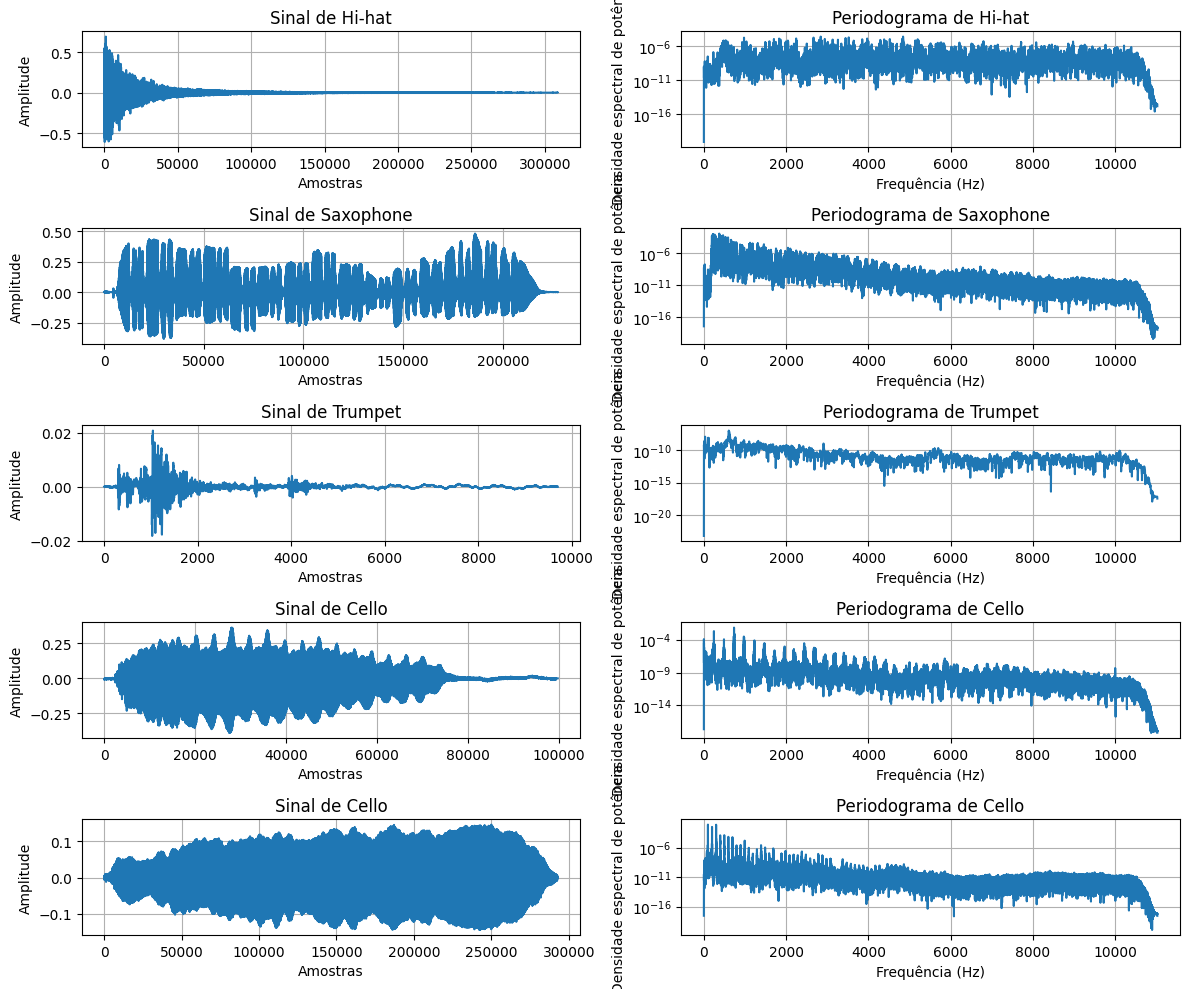

In [ ]:
import librosa
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Diretorio com os audios de treino
audio_folder_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.audio_train/"

num_examples = 5
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 10))

for i in range(num_examples):
    row = df_instruments.iloc[i]
    audio_path = audio_folder_path + row['fname']

    # Carrega o áudio
    audio, sr = librosa.load(audio_path)

    # Calcula periodograma
    f, Pxx = periodogram(audio, fs=sr)

    # Plota o sinal original
    axes[i, 0].plot(audio)
    axes[i, 0].set_xlabel("Amostras")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].set_title(f"Sinal de {row['label']}")
    axes[i, 0].grid()

    # Plota o periodograma
    axes[i, 1].semilogy(f, Pxx)
    axes[i, 1].set_xlabel("Frequência (Hz)")
    axes[i, 1].set_ylabel("Densidade espectral de potência")
    axes[i, 1].set_title(f"Periodograma de {row['label']}")
    axes[i, 1].grid()

plt.tight_layout()
plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####**3.2.2 Espectrogramas e Espectogramas na escala Mel**

Além dos periodogramas, empregamos também espectrogramas, que representam a evolução das frequências ao longo do tempo. O espectrograma é obtido a partir da Transformada de Fourier de Curto Tempo (STFT) e fornece uma visão detalhada da dinâmica do sinal sonoro, permitindo capturar variações temporais que são fundamentais para distinguir diferentes instrumentos musicais. A representação espectral gerada é utilizada como entrada para a rede CNN, possibilitando que o modelo aprenda padrões relevantes na classificação dos instrumentos.

Convertendo a escala para logarítmica, podemos obter o espectograma em Decibéis. O ouvido humano percebe a intensidade do som de forma logarítmica, e a escala dB ajuda a destacar detalhes em níveis de energia mais baixos.

Além disso, podemos utilizar a escala Mel para representar os espectrogramas. Ao converter da escala Hertz para a escala Mel, a representação torna-se mais sensível a variações nas frequências baixas e menos sensível a variações nas frequências altas.
![aaaa](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Mel-Hz_plot.svg/675px-Mel-Hz_plot.svg.png)

No trecho de código abaixo, iremos calcular os espectogramas para os primeiros 5 arquivos de áudio:











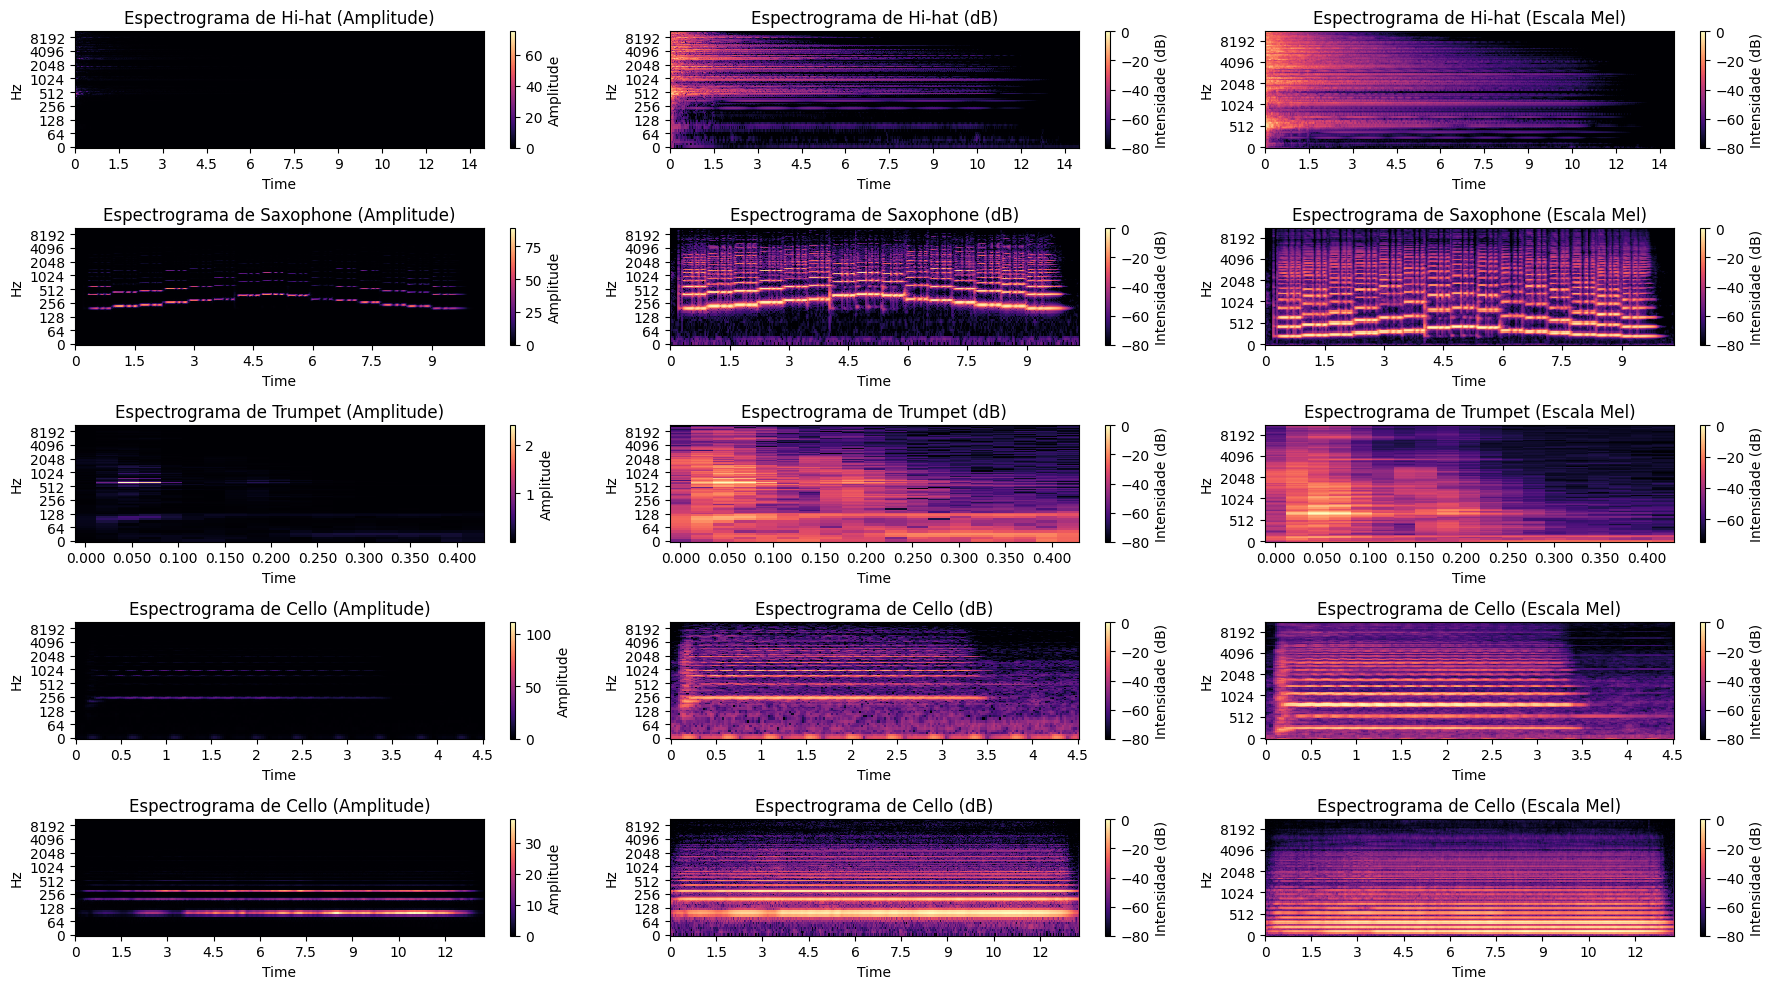

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Definir o número de exemplos a serem plotados
num_examples = 5

# Criar subplots com três colunas
fig, axes = plt.subplots(num_examples, 3, figsize=(18, 10))

for i in range(num_examples):
    row = df_instruments.iloc[i]
    audio_path = audio_folder_path + row['fname']

    # Carregar o áudio
    y, sr = librosa.load(audio_path, sr=22050)

    # Calcular espectrograma comum (em amplitude)
    spectrogram = np.abs(librosa.stft(y))

    # Plotar espectrograma comum (em amplitude)
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='log', sr=sr, ax=axes[i, 0])
    axes[i, 0].set_title(f"Espectrograma de {row['label']} (Amplitude)")
    axes[i, 0].figure.colorbar(librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 0]), ax=axes[i, 0], label='Amplitude')

    # Calcular espectrograma em escala decibel (dB)
    db_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

    # Plotar espectrograma em escala decibel (dB)
    librosa.display.specshow(db_spectrogram, x_axis='time', y_axis='log', sr=sr, ax=axes[i, 1])
    axes[i, 1].set_title(f"Espectrograma de {row['label']} (dB)")
    axes[i, 1].figure.colorbar(librosa.display.specshow(db_spectrogram, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1]), ax=axes[i, 1], label='Intensidade (dB)')

    # Gerar espectrograma na escala Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plotar espectrograma na escala Mel
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', ax=axes[i, 2])
    axes[i, 2].set_title(f"Espectrograma de {row['label']} (Escala Mel)")
    axes[i, 2].figure.colorbar(librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', ax=axes[i, 2]), ax=axes[i, 2], label='Intensidade (dB)')

plt.tight_layout()
plt.show()

####**3.2.3 Signal Enveloping**

Numa faixa de áudio, muitas vezes a magnitude da amplitude se torna muito pequena por muito tempo. Isso gera um problema no qual muitas faixas de áudio de diferentes instrumentos aparentam ter as mesmas características. Por exemplo, uma guitarra e um hi-hat poderiam ter sinais parecidos já que possuem tempos parecidos de "dead space" em seu arquivo de áudio e portanto o Modelo reconheceria como sendo entradas de um mesmo instrumento.

Para prevenir esse cenário, faremos um tratamento das faixas de áudio conhecido como Signal Enveloping, onde aplicamos um envelope ao sinal para destacar suas variações de amplitude ao longo do tempo. Esse processo consiste em suavizar as flutuações rápidas do sinal, permitindo que padrões mais relevantes sejam preservados e facilitando a distinção entre diferentes instrumentos.

Com essa abordagem, buscamos minimizar o impacto de períodos de baixa amplitude e garantir que o modelo de CNN consiga aprender características mais representativas dos instrumentos musicais.

In [ ]:
import numpy as np

def envelope(y, rate, threshold):
    y_abs = np.abs(y)  # Obtém o valor absoluto do sinal
    y_mean = pd.Series(y_abs).rolling(window=int(rate/20), min_periods=1, center=True).max()
    mask = (y_mean > threshold).to_numpy()  # Converte a máscara para numpy
    return mask, y_mean.to_numpy()


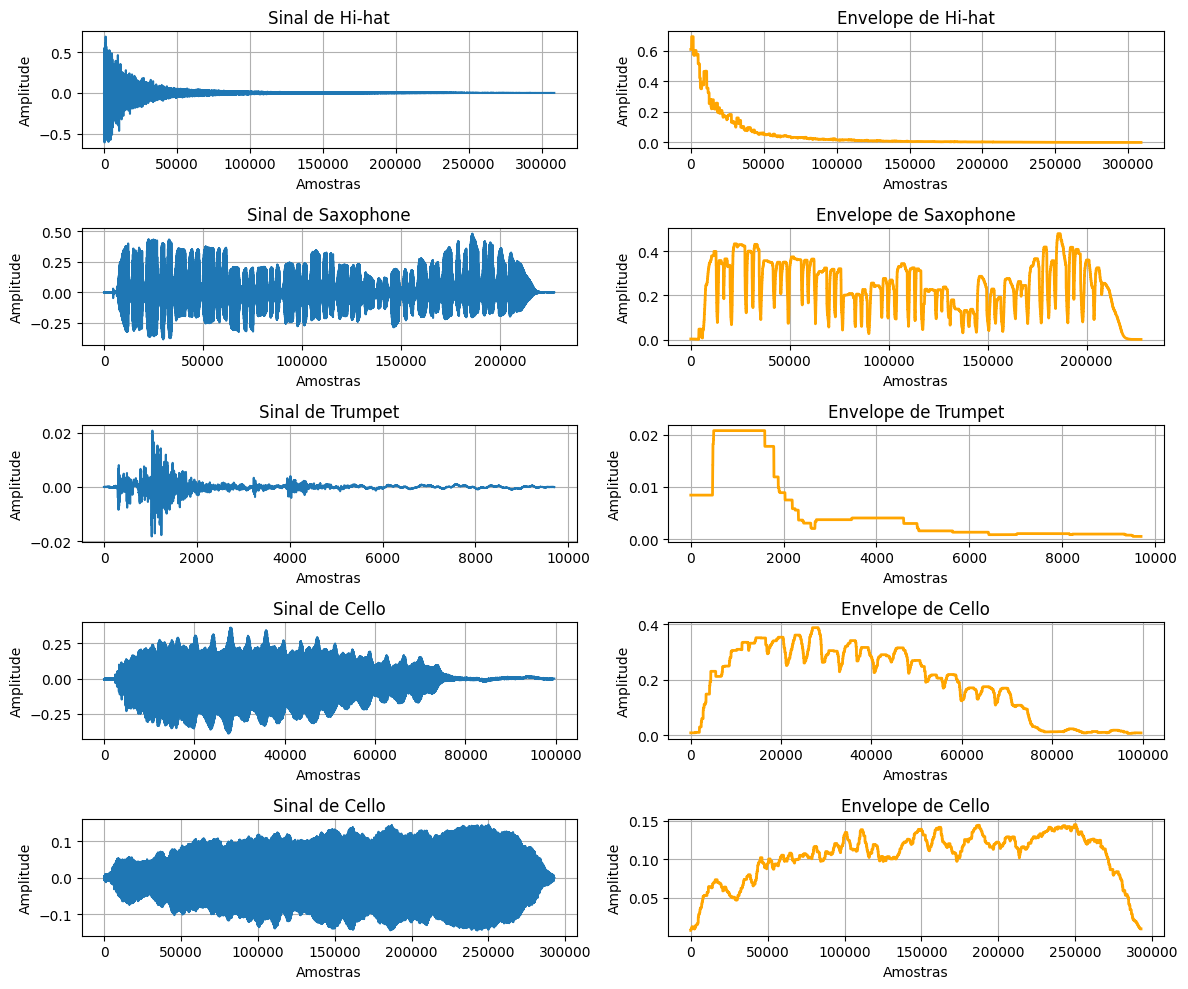

In [ ]:
audio_folder_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.audio_train/"

num_examples = 5

fig, axes = plt.subplots(num_examples, 2, figsize=(12, 10))

for i in range(num_examples):
    row = df_instruments.iloc[i]
    audio_path = audio_folder_path + row['fname']

    # faixa de audio
    audio, sr = librosa.load(audio_path)

    threshold = 0.02
    # carrega o envelope
    mask, y_mean = envelope(audio, sr, threshold)

    # Plotar o sinal original
    axes[i, 0].plot(audio)
    axes[i, 0].set_xlabel("Amostras")
    axes[i, 0].set_ylabel("Amplitude")
    axes[i, 0].set_title(f"Sinal de {row['label']}")
    axes[i, 0].grid()

    # Plotar o envelope
    axes[i, 1].plot(y_mean, label="Envelope", color='orange', linewidth=2)
    axes[i, 1].set_xlabel("Amostras")
    axes[i, 1].set_ylabel("Amplitude")
    axes[i, 1].set_title(f"Envelope de {row['label']}")
    axes[i, 1].grid()

plt.tight_layout()
plt.show()

#### 3.2.4 Downsampling, conversão para Mono
Os arquivos do dataset utilizado possuem diferentes taxas de amostragem (exemplo: 44.1 kHz e 16 kHz) e podem estar em estéreo ou mono. Como redes neurais funcionam melhor com dados padronizados, precisamos processar esses arquivos para garantir que todos tenham a mesma taxa de amostragem e estejam no formato de áudio mono.

Downsampling: Reduzimos a taxa de amostragem dos arquivos para um valor fixo, uniformizando as faixas de áudio e reduzindo a carga computacional.

Conversão para Mono: Se o áudio for estéreo, combinamos os dois canais em um único canal.

Para extrairmos algumas informações da faixa de áudio, precisamos da biblioteca "wavio", que será instalada em seguida.

A função downsample_mono() é responsável por ler o arquivo .wav e extrair os dados de áudio e a taxa de amostragem original. Converte para mono, caso necessário, e ajusta o áudio para a taxa de amostragem definida.

A função split_wavs() é responsável por estruturar o processo. Ela também realiza a segmentação dos arquivos de áudio em faixas de 1 segundo. Faixas de áudio muito longas geram espectogramas muito detalhados, o que aumenta muito o custo computacional e pode resultar num modelo mais difícil de generalizar. Faixas mais curtas, de 1 segundo, garantem tamanhos padronizados para entrada da rede, reduzindo a complexidade. Essa função então percorre os arquivos do diretório de entrada, garantindo que apenas os arquivos presentes no dataset sejam processados, e, em cada arquivo:

O áudio passa pelo downsampling e conversão para mono;
É aplicada uma função de envelopamento;
O áudio é segmentado para um trecho de 1 segundo;


Caso o trecho tenha menos de 1 segundo, ele é preenchido com zeros para manter um comprimento fixo.

In [ ]:
!pip install wavio

In [ ]:
import wavio
from librosa.core import resample, to_mono

def downsample_mono(path, sr):
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
        pass
    except Exception as exc:
        raise exc
    wav = resample(wav.astype(float), orig_sr=rate, target_sr=sr)
    wav = wav.astype(np.int16)
    return sr, wav

In [ ]:
import os
from scipy.io import wavfile
from glob import glob
from tqdm import tqdm


test_csv_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv"
train_csv_path = os.path.abspath("filtered_instruments.csv")

df_train = pd.read_csv(train_csv_path)
unique_labels_train = sorted(df_train['label'].unique())

# Define os labels únicos a partir do conjunto de treinamento
unique_labels = sorted(df_train['label'].unique())
print("Unique labels:", unique_labels)

# Lê o CSV de teste
df_test = pd.read_csv(test_csv_path)

# Filtra o CSV de teste para manter apenas os exemplos cujos rótulos estão em unique_labels
df_test = df_test[df_test['label'].isin(unique_labels)]
print("Número de amostras de teste após filtragem:", len(df_test))


# Função para salvar o áudio
def save_sample(sample, rate, target_dir, fn):
    fn = fn.split('.wav')[0]
    dst_path = os.path.join(target_dir, '{}.wav'.format(fn))
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)


def check_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def split_wavs(args):
    src_root = args.src_root
    dst_root = args.dst_root
    dt = args.delta_time

    df = pd.read_csv(args.csv_file)
    wav_paths = df['fname'].values

    check_dir(dst_root)

    for fn in tqdm(os.listdir(src_root)):
        src_fn = os.path.join(src_root, fn)

        if os.path.isfile(src_fn):
            if fn in wav_paths:  # Verifica se o arquivo está na lista do CSV
                rate, wav = downsample_mono(src_fn, args.sr)  # Downsample
                mask, y_mean = envelope(wav, rate, threshold=args.threshold)  # Envelopamento
                wav = wav[mask]

                # Cortar 1 segundo de áudio (faixa de 1 segundo)
                one_second_sample = rate  # 1 segundo de amostras
                wav_1_second = wav[:one_second_sample]  # Pega apenas a primeira faixa de 1 segundo

                # Verificar se o áudio tem pelo menos 1 segundo
                if wav_1_second.shape[0] < one_second_sample:
                    wav_1_second = np.pad(wav_1_second, (0, one_second_sample - wav_1_second.shape[0]), mode='constant')

                # Salvar o áudio
                save_sample(wav_1_second, rate, dst_root, fn)

Unique labels: ['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Gong', 'Hi-hat', 'Oboe', 'Saxophone', 'Snare_drum', 'Trumpet', 'Violin_or_fiddle']
Número de amostras de teste após filtragem: 685


In [ ]:
class Args:
    def __init__(self):
        # self.csv_file = train_csv_path
        # self.src_root = '/content/drive/MyDrive/AudioClassification/FSDKaggle2018.audio_train/'
        # self.dst_root = '/content/drive/MyDrive/AudioClassification/split_wavs_1_sec_train/'
        self.csv_file = test_csv_path
        self.src_root = '/content/drive/MyDrive/AudioClassification/FSDKaggle2018.audio_test/'
        self.dst_root = '/content/drive/MyDrive/AudioClassification/split_wavs_1_sec_test/'

        self.sr = 22050  # Taxa de amostragem
        self.delta_time = 1  # Intervalo de tempo (em segundos) para dividir os arquivos
        self.threshold = 0.02  # Threshold para o envelope do sinal

args = Args()
split_wavs(args)

100%|██████████| 1600/1600 [03:01<00:00,  8.83it/s]


Nos blocos de código abaixo, geramos as imagens dos espectogramas para treino e teste, utilizando a escala em Db e a escala Mel

In [ ]:
def generate_mel_scale(audio_folder_path, output_folder, instrument_files):
    # cria dir se não existir
    os.makedirs(output_folder, exist_ok=True)
    # instrument_files = set(df_instruments["fname"])
    print("instrument_files: ", instrument_files)

    for filename in os.listdir(audio_folder_path):
        if filename.endswith(".wav") and filename in instrument_files:
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")

            if os.path.exists(output_path):
                continue

            audio_path = os.path.join(audio_folder_path, filename)

            # Carregar o áudio
            y, sr = librosa.load(audio_path, sr=22050)

            # Gerar espectrograma na escala Mel
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # tira axis
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.set_axis_off()

            # tira rotulo, cor, margem
            img = librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis=None, y_axis=None, cmap='magma', ax=ax)

            # Ajustar os limites para remover espaços em branco
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

            print(f"Criando arquivo {output_path}.")
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()


train_files = set(df_train['fname'].values)
test_files = set(df_test['fname'].values)

print("treino: ", train_files)
print("teste: ", test_files)

audio_train_path = "/content/drive/MyDrive/AudioClassification/split_wavs_1_sec"
mel_train_output = "/content/drive/MyDrive/AudioClassification/mel_scale_train"
generate_mel_scale(audio_train_path, mel_train_output, train_files)

audio_test_path = "/content/drive/MyDrive/AudioClassification/split_wavs_1_sec_test"
test_mel_output = "/content/drive/MyDrive/AudioClassification/mel_scale_test"
generate_mel_scale(audio_test_path, test_mel_output, test_files)

treino:  {'b774db41.wav', '4f60abb7.wav', '20b1a46c.wav', 'a0678493.wav', '24eacf14.wav', 'dfb8afae.wav', 'f6a3a18f.wav', '5bdb30ae.wav', '8c452b56.wav', 'c424d929.wav', '48ba4a7a.wav', '3251bac1.wav', '368137a8.wav', '2013a12f.wav', '35e97db3.wav', '15cade34.wav', '275b9330.wav', '9bf2f8d2.wav', 'aa909ac6.wav', '9346e7b5.wav', '940ccc5e.wav', 'ad999a17.wav', 'c33d0c95.wav', 'c8bb8a34.wav', '373f60bf.wav', '327a2509.wav', '08dba5f4.wav', 'a5c92b8f.wav', 'f093caf9.wav', '61e4de0f.wav', 'aca975c3.wav', '91c86274.wav', 'e61c41dc.wav', 'fcc56f50.wav', '4bc87056.wav', 'f71056a8.wav', '1c133d0e.wav', '87a2b293.wav', '7e5c47c9.wav', 'bb47c6a3.wav', '10357e1e.wav', '66bcf27e.wav', 'c53a217e.wav', 'dee0d5ac.wav', '06ed75a7.wav', 'aad3fd7a.wav', 'd4bd0cce.wav', 'e3496042.wav', '53dda34d.wav', '40772f25.wav', '26fce215.wav', '53b70883.wav', '6c329938.wav', '7baf18f6.wav', '570742db.wav', 'e21049af.wav', 'a0476541.wav', '80ef109f.wav', '00cb787c.wav', 'e493b9b6.wav', '1b9386ef.wav', 'be6c0570.wav'

In [ ]:
def generate_db_scale(audio_folder_path, output_folder, instrument_files):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(audio_folder_path):
        if filename.endswith(".wav") and filename in instrument_files:
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")

            if os.path.exists(output_path):
                continue

            audio_path = os.path.join(audio_folder_path, filename)

            # Carregar o áudio
            y, sr = librosa.load(audio_path, sr=22050)

            # Calcular espectrograma comum (STFT em amplitude)
            spectrogram = np.abs(librosa.stft(y))

            # Converter para escala de decibéis (dB)
            db_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

            # Criar figura sem eixos e sem margens
            fig, ax = plt.subplots(figsize=(4, 4))
            ax.set_axis_off()

            # Exibir o espectrograma sem rótulos, margens ou eixos
            librosa.display.specshow(db_spectrogram, sr=sr, x_axis=None, y_axis=None, cmap='magma', ax=ax)

            # Ajustar os limites para remover espaços em branco
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

            # Salvar a imagem sem bordas
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()


audio_train_path = "/content/drive/MyDrive/AudioClassification/split_wavs_1_sec"
db_train_output = "/content/drive/MyDrive/AudioClassification/db_scale_train"
generate_db_scale(audio_train_path, db_train_output, train_files)

test_audio_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.audio_test"
test_db_output = "/content/drive/MyDrive/AudioClassification/db_scale_test"
generate_db_scale(test_audio_path, test_db_output, test_files)

In [ ]:
from PIL import Image

train_mel_folder = "/content/drive/MyDrive/AudioClassification/mel_scale_train"
test_mel_folder = "/content/drive/MyDrive/AudioClassification/mel_scale_test"

mel_train_sample_image = os.listdir(train_mel_folder)[0]
mel_train_image_path = os.path.join(train_mel_folder, mel_train_sample_image)

mel_test_sample_image = os.listdir(test_mel_folder)[0]
mel_image_path = os.path.join(test_mel_folder, mel_test_sample_image)

# dimensao de uma imagem do espectograma de mel
mel_train_img = Image.open(mel_train_image_path)
mel_test_img = Image.open(mel_image_path)
print(f"Dimensões do espectograma de mel de treino: {mel_train_img.size}")  # (largura, altura)
print(f"Dimensões do espectograma de mel de teste: {mel_test_img.size}")  # (largura, altura)


###############################         ###############################
#                              decibeis                               #
###############################         ###############################


train_db_folder = "/content/drive/MyDrive/AudioClassification/db_scale_train"
test_db_folder = "/content/drive/MyDrive/AudioClassification/db_scale_test"


db_train_sample_image = os.listdir(train_db_folder)[0]
db_train_image_path = os.path.join(train_db_folder, db_train_sample_image)

db_test_sample_image = os.listdir(test_db_folder)[0]
db_test_image_path = os.path.join(test_db_folder, db_test_sample_image)

# dimensao de uma imagem do espectograma de decibeis
db_train_img = Image.open(db_train_image_path)
db_test_img = Image.open(db_test_image_path)
print(f"Dimensões do espectograma de db de treino: {db_train_img.size}")  # (largura, altura)
print(f"Dimensões do espectograma de db de teste: {db_test_img.size}")  # (largura, altura)


Dimensões do espectograma de mel de treino: (400, 400)
Dimensões do espectograma de mel de teste: (400, 400)
Dimensões do espectograma de db de treino: (400, 400)
Dimensões do espectograma de db de teste: (400, 400)


#### 3.2.5 Separação dos conjuntos de treino e teste

A partir dos espectogramas gerados, no código abaixo, criamos a função, load_and_normalize_images, para criar arrays de treino e teste. Cada imagem gerada, possui 400x400 pixels, a função as redimensiona para 64x64 e normaliza para valores entre 0 e 1. Fazemos o mesmo procedimento para o conjunto de treino e teste.


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

# Caminhos para os arquivos CSV e diretórios das imagens
train_csv_path = "filtered_instruments.csv"
test_csv_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv"
base_image_path = "/content/drive/MyDrive/AudioClassification/mel_scale_train/"
base_test_image_path = "/content/drive/MyDrive/AudioClassification/mel_scale_test/"

# Função para carregar e normalizar as imagens
def load_and_normalize_images(image_paths, target_size):
    images = []
    for path in image_paths:
        try:
            # Abre a imagem
            image = Image.open(path)
            # Redimensiona a imagem para o tamanho alvo
            image = image.resize(target_size)
            # Converte a imagem para um array numpy
            image = np.array(image)
            # Normaliza os valores dos pixels para [0, 1]
            image = image.astype('float32') / 255
            images.append(image)
        except Exception as e:
            print(f"Erro ao processar {path}: {e}")
    return np.array(images)

# Lê o CSV de treinamento
df_train = pd.read_csv(train_csv_path)

# Gera os caminhos completos das imagens de treinamento
train_image_paths = [base_image_path + fname.replace(".wav", ".png") for fname in df_train['fname']]

# Define o tamanho alvo para as imagens
target_size = (64, 64)

# Carrega e normaliza as imagens de treinamento
X_train = load_and_normalize_images(train_image_paths, target_size)

# Define os labels únicos a partir do conjunto de treinamento
unique_labels = sorted(df_train['label'].unique())
print("Unique labels:", unique_labels)
print("Formato das imagens de treinamento:", X_train.shape)

# Lê o CSV de teste
df_test = pd.read_csv(test_csv_path)

# Filtra o CSV de teste para manter apenas os exemplos cujos rótulos estão em unique_labels
df_test = df_test[df_test['label'].isin(unique_labels)]
print("Número de amostras de teste após filtragem:", len(df_test))

# Gera os caminhos completos das imagens de teste usando o diretório correto
test_image_paths = [base_test_image_path + fname.replace(".wav", ".png") for fname in df_test['fname']]

# Carrega e normaliza as imagens de teste
X_test = load_and_normalize_images(test_image_paths, target_size)
print("Formato das imagens de teste:", X_test.shape)


Unique labels: ['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Gong', 'Hi-hat', 'Oboe', 'Saxophone', 'Snare_drum', 'Trumpet', 'Violin_or_fiddle']
Formato das imagens de treinamento: (3891, 64, 64, 4)
Número de amostras de teste após filtragem: 685
Formato das imagens de teste: (685, 64, 64, 4)


Separando agora para a escala em decibel

In [ ]:
# Caminhos para os arquivos CSV e diretórios das imagens
train_csv_path = "filtered_instruments.csv"
test_csv_path = "/content/drive/MyDrive/AudioClassification/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv"
base_image_path = "/content/drive/MyDrive/AudioClassification/db_scale_train/"
base_test_image_path = "/content/drive/MyDrive/AudioClassification/db_scale_test/"

# Lê o CSV de treinamento
df_train_db = pd.read_csv(train_csv_path)

# Gera os caminhos completos das imagens de treinamento
train_image_paths = [base_image_path + fname.replace(".wav", ".png") for fname in df_train_db['fname']]

# Define o tamanho alvo para as imagens
target_size = (64, 64)

# Carrega e normaliza as imagens de treinamento
X_train_db = load_and_normalize_images(train_image_paths, target_size)

# Define os labels únicos a partir do conjunto de treinamento
unique_labels = sorted(df_train_db['label'].unique())
print("Unique labels:", unique_labels)
print("Formato das imagens de treinamento:", X_train_db.shape)

# Lê o CSV de teste
df_test_db = pd.read_csv(test_csv_path)

# Filtra o CSV de teste para manter apenas os exemplos cujos rótulos estão em unique_labels
df_test_db = df_test_db[df_test_db['label'].isin(unique_labels)]
print("Número de amostras de teste após filtragem:", len(df_test_db))

# Gera os caminhos completos das imagens de teste usando o diretório correto
test_image_paths_db = [base_test_image_path + fname.replace(".wav", ".png") for fname in df_test_db['fname']]

# Carrega e normaliza as imagens de teste
X_test_db = load_and_normalize_images(test_image_paths_db, target_size)
print("Formato das imagens de teste:", X_test_db.shape)

Unique labels: ['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Gong', 'Hi-hat', 'Oboe', 'Saxophone', 'Snare_drum', 'Trumpet', 'Violin_or_fiddle']
Formato das imagens de treinamento: (3891, 64, 64, 4)
Número de amostras de teste após filtragem: 685
Formato das imagens de teste: (685, 64, 64, 4)


### **3.3. Criando os Modelos**

Antes de definir o modelo, criamos o conjunto de labels target para os conjuntos de treino e teste, convertendo-os para índices numéricos e one-hot encoding.

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np


labels_train = df_train['label']
unique_labels = sorted(labels_train.unique())  # Garante ordem consistente
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Converte os rótulos de treinamento para índices numéricos e depois para one-hot encoding
y_train_indices = np.array([label_to_index[label] for label in labels_train])
num_classes = len(unique_labels)
y_train = to_categorical(y_train_indices, num_classes)

print(y_train.shape)  # (número_de_imagens_train, num_classes)

labels_test = df_test['label']

df_test = df_test[df_test['label'].isin(unique_labels)]
labels_test = df_test['label']

# Converte os rótulos de teste para índices numéricos e depois para one-hot encoding
y_test_indices = np.array([label_to_index[label] for label in labels_test])
y_test = to_categorical(y_test_indices, num_classes)

print(y_test.shape)  # (número_de_imagens_test, num_classes)


(3891, 13)
(685, 13)


Fazendo o mesmo agora para a escala em decibel

In [ ]:
# Para treinamento
labels_train_db = df_train_db['label']
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_train_indices_db = np.array([label_to_index[label] for label in labels_train_db])
num_classes = len(unique_labels)
y_train_db = to_categorical(y_train_indices_db, num_classes)
print("Formato dos rótulos de treinamento:", y_train_db.shape)# (número_de_imagens_train, num_classes)

# Para teste
labels_test_db = df_test_db['label']
y_test_indices_db = np.array([label_to_index[label] for label in labels_test_db])
y_test_db = to_categorical(y_test_indices_db, num_classes)
print("Formato dos rótulos de teste:", y_test_db.shape)# (número_de_imagens_train, num_classes)


Formato dos rótulos de treinamento: (3891, 13)
Formato dos rótulos de teste: (685, 13)


A partir dos conjuntos de treino e teste, e seus respectivos targets, agora podemos treinar nosso modelo. Utilizamos uma topologia baseada no artigo [4], que segue:

- Função de ativação: ReLU
- 4 camada convolucionais
- 1 Camada de achatamento (para alimentar a camada densa)
- 2 Camadas densas
- Otimizador: Adam
- Função de perda: Entropia cruzada (Para classificação multiclasse)
- Batch Size: 32
- Número de épocas: 100

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 4)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 259ms/step - accuracy: 0.0835 - loss: 2.5653 - val_accuracy: 0.1181 - val_loss: 2.4964
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.1648 - loss: 2.4561 - val_accuracy: 0.2157 - val_loss: 2.2357
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 262ms/step - accuracy: 0.2407 - loss: 2.2146 - val_accuracy: 0.3338 - val_loss: 1.9604
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.3200 - loss: 1.9813 - val_accuracy: 0.3813 - val_loss: 1.8159
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.3685 - loss: 1.8488 - val_accuracy: 0.4134 - val_loss: 1.7269
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.3902 - loss: 1.8023 - val_accuracy: 0.4570 - val_loss: 1.6656
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.4544 - loss: 1.6441 - val_accuracy: 0.5006 - val_loss: 1.5268
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.4858 - loss: 1.5428 - 

In [ ]:
print(f"Acurácia no conjunto de teste: {model.evaluate(X_test, y_test, verbose=0)[1]}")

Acurácia no conjunto de teste: 0.8014598488807678


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_db = Sequential()

model_db.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 4)))
model_db.add(MaxPooling2D((2, 2)))

model_db.add(Conv2D(64, (3, 3), activation='relu'))
model_db.add(MaxPooling2D((2, 2)))
model_db.add(Dropout(0.5))

model_db.add(Conv2D(128, (3, 3), activation='relu'))
model_db.add(MaxPooling2D((2, 2)))
model_db.add(Dropout(0.5))

model_db.add(Conv2D(128, (3, 3), activation='relu'))
model_db.add(MaxPooling2D((2, 2)))

model_db.add(Flatten())

model_db.add(Dense(128, activation='relu'))
model_db.add(Dropout(0.5))

model_db.add(Dense(128, activation='relu'))
model_db.add(Dropout(0.5))

model_db.add(Dense(num_classes, activation='softmax'))

model_db.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_db.summary()

# Treina o modelo utilizando as variáveis X_train_db e y_train_db
model_db.fit(X_train_db, y_train_db, epochs=100, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 62, 62, 32)          │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 13)                  │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,973 (1.24 MB)

 Trainable params: 324,973 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - accuracy: 0.0853 - loss: 2.5577 - val_accuracy: 0.1900 - val_loss: 2.4897
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.1710 - loss: 2.3949 - val_accuracy: 0.2426 - val_loss: 2.3674
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.1928 - loss: 2.3268 - val_accuracy: 0.2054 - val_loss: 2.3584
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.2201 - loss: 2.2528 - val_accuracy: 0.2285 - val_loss: 2.2475
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.2261 - loss: 2.1922 - val_accuracy: 0.2336 - val_loss: 2.2167
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.2294 - loss: 2.1729 - val_accuracy: 0.2606 - val_loss: 2.1838
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.2753 - loss: 2.0707 - val_accuracy: 0.2516 - val_loss: 2.1399
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 256ms/step - accuracy: 0.3132 - loss: 1.9929 - 

In [ ]:
print(f"Acurácia no conjunto de teste: {model_db.evaluate(X_test_db, y_test_db, verbose=0)[1]}")

Acurácia no conjunto de teste: 0.3328467011451721


#**4. Resultados**

Resultados obtidos no conjunto de teste:
- Acurácia Mel Scale: 80,14%
- Acurácia Decibels Scale: 33,28%

Os gráficos a seguir apresentam as matrizes de confusão da Escala de Decibéis e da Escala Mel, respectivamente, destacando as classes com maior taxa de erro e possíveis padrões de confusão entre os instrumentos:

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


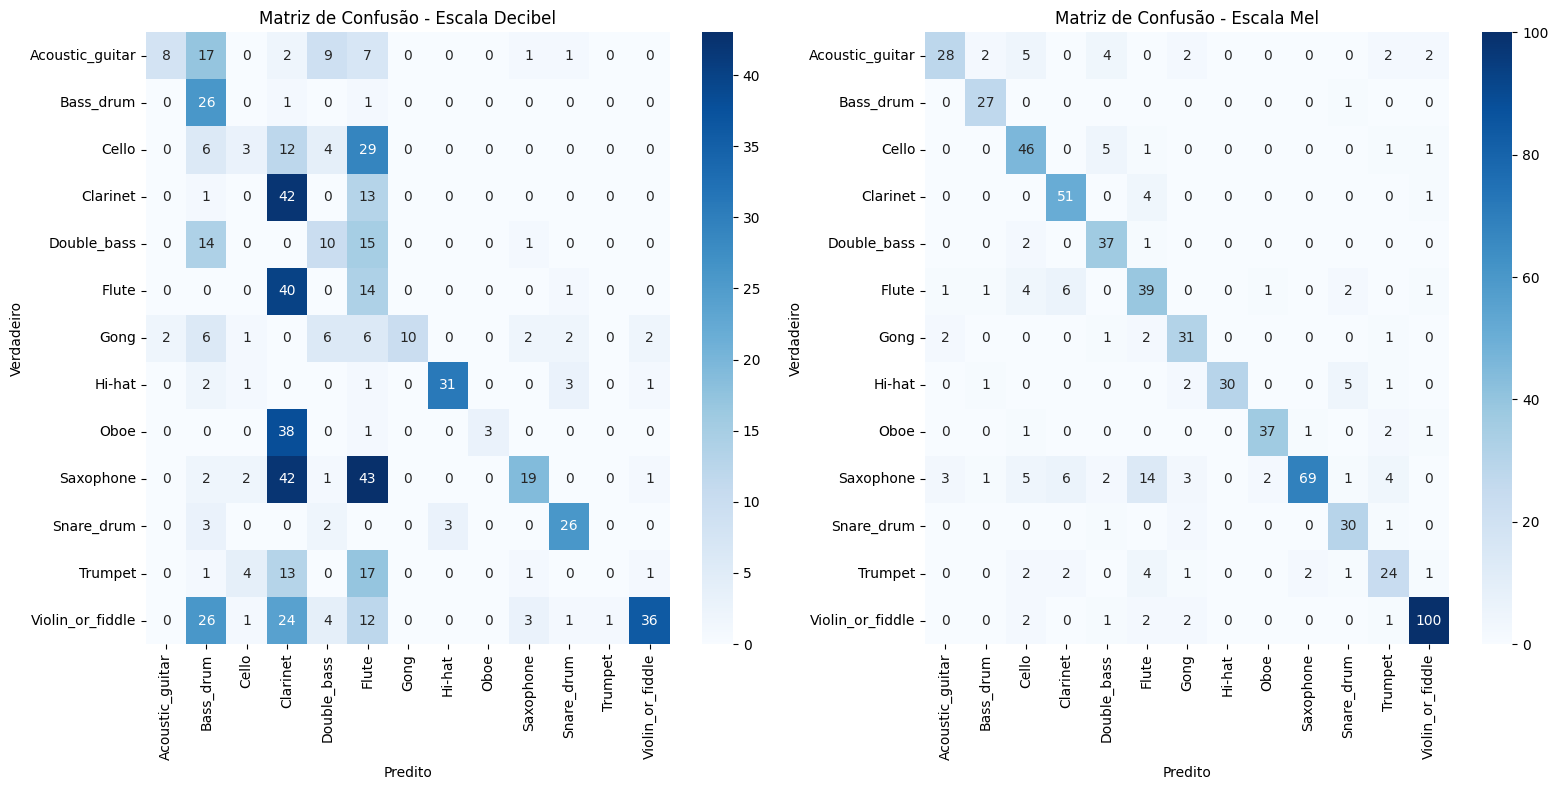

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

instrument_classes = sorted(df_train['label'].unique())

# Previsões dos modelos
y_pred_db = model_db.predict(X_test_db)
y_pred_mel = model.predict(X_test)

# Converte as previsões de one-hot encoding para rótulos
y_pred_labels_db = np.argmax(y_pred_db, axis=1)
y_pred_labels_mel = np.argmax(y_pred_mel, axis=1)

# Converte os rótulos verdadeiros de one-hot encoding para rótulos
y_true_labels_db = np.argmax(y_test_db, axis=1)
y_true_labels_mel = np.argmax(y_test, axis=1)

# Calcula as matrizes de confusão
conf_matrix_db = confusion_matrix(y_true_labels_db, y_pred_labels_db)
conf_matrix_mel = confusion_matrix(y_true_labels_mel, y_pred_labels_mel)

# Cria uma figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot da matriz de confusão para o modelo na escala decibel
sns.heatmap(conf_matrix_db, annot=True, fmt='d', cmap='Blues',
             xticklabels=instrument_classes, yticklabels=instrument_classes, ax=axes[0])
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')
axes[0].set_title('Matriz de Confusão - Escala Decibel')

# Plot da matriz de confusão para o modelo na escala Mel
sns.heatmap(conf_matrix_mel, annot=True, fmt='d', cmap='Blues',
             xticklabels=instrument_classes, yticklabels=instrument_classes, ax=axes[1])
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Verdadeiro')
axes[1].set_title('Matriz de Confusão - Escala Mel')

plt.tight_layout()
plt.show()


Observando as matrizes de confusão, vemos que a da escala Mel possui menos erros em comparação com a da escala Decibel, o que se confirma pela acurácia maior. A diagonal principal é muito mais clara na matriz da escala Mel.

#**5. Conclusão**
Comparando os dois modelos, vemos que o modelo que utiliza a escala Mel, se saiu melhor que o que utilizou a escala em decibéis, sendo os dois com a mesma topologia. Para melhorar mais o desempenho do modelo poderiamos adotar estratégias como:
- Extrair ainda mais features[5] das faixas de áudio, como:  Zero-crossing rate, centroide espectral, rool-off espectral, entre outros.
- Aumento de Dados: Aplicar técnicas de data augmentation para gerar mais amostras, como cropar as faixas de áudio em N faixas de 1 segundo, e não apenas em uma faixa. Poderíamos ainda aumentar o nosso conjunto de dados com entradas de diferentes fontes, como as de outros desafios do Kaggle.
- Ajuste de Hiperparâmetros: Refinar a arquitetura da rede, trocando o número de camadas, aplicando filtros e alterando valores de taxa de aprendizado/épocas.
- Uso de Modelos Pré-Treinados: consideramos o uso de transfer learning no início para aproveitarmos redes já treinadas em tarefas similares. No entanto, parte do nosso objetivo era analisar o comportamento de diferentes entradas de treino num modelo, então optamos por treinarmos nossa rede do zero.

Com essas melhorias, acreditamos que o modelo pode alcançar uma classificação ainda mais precisa na identificação de instrumentos musicais.


#**6. Referências**
<br>


* [1] Fonseca, Eduardo; "GENERAL-PURPOSE TAGGING OF FREESOUND AUDIO WITH AUDIOSET LABELS:TASK DESCRIPTION, DATASET, AND BASELINE". https://arxiv.org/pdf/1807.09902. Acesso em: 15/02/2025.
* [2] Choi, Keunwoo; "Kapre: On-GPU Audio Preprocessing Layers for a Quick Implementation of Deep Neural Network Models with Keras." https://arxiv.org/pdf/1706.05781. Acesso em: 15/02/2025.
* [3] Freesound General-Purpose Audio Tagging Challenge: https://www.kaggle.com/c/freesound-audio-tagging/data
* [4] Massoudi, Massoud. Urban Sound Classification using CNN. Doi: 10.1109/icict50816.2021.9358621
* [5] Yu, Dongyan. "Predominant Instrument Recognition Based on Deep
Neural Network With Auxiliary Classification". Doi: 10.1109/TASLP.2020.2971419




